In [6]:
%matplotlib notebook
import sys
sys.path.append('/opt/proteus/linux/bin')
import os
os.environ['PATH']+=':/opt/proteus/linux/bin'
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import numpy as np
import math
from proteus.iproteus import *
import proteus.default_p as physics 
import proteus.default_n as numerics
from proteus import WaveTools as wt
from proteus.TransportCoefficients import PoissonEquationCoefficients

#----------------------------------------------------------------
# define Laplace coefficients
#----------------------------------------------------------------
def r(x):
    return 0.
def a(x):
    return np.array([[1.0,0.0],
                     [0.0,1.0]])

ipt = Context.Options([
    ("final_time",20.0,"Final time for simulation"),
    ("sampleRate",0.05,"Time interval to output solution"),
    ("cfl",0.33,"Desired CFL restriction"),
    ("he",0.08,"Max mesh element diameter"),
    ("mwl",0.2,"still water depth"),
    ("Hm",0.07,"Wave height"),
    ("fast", False, "switch for fast cosh calculations in WaveTools"),
    ("x0", -5., "Starting place of solitary wave"),
    ("toe_x",13.6,"x coordinate of seawall's toe"),
    ("toe_y",0.18,"y coordinate of seawall's toe"),
    ("slope",0.076/0.3,"slope of the seawall"),
    ("dt_init", 0.001, "Initial time step"),
#     ("dt_out", 0.01, "output time interval"),
    ("nsave",  10, "Number of time steps to save per second"),
    ])

# general options
# sim time
T = ipt.final_time

# initial step
dt_init = ipt.dt_init

nDTout = int(T*ipt.nsave)
if nDTout > 0:
    dt_out= (T-dt_init)/nDTout
else:
    dt_out = 0

# CFL value
cfl = ipt.cfl

# mesh size
he = ipt.he

# rate at which values are recorded
sampleRate = ipt.sampleRate

# water density
rho_0 = 998.2

# gravitational acceleration
grav = 9.81
g = np.array([0., -grav, 0.])

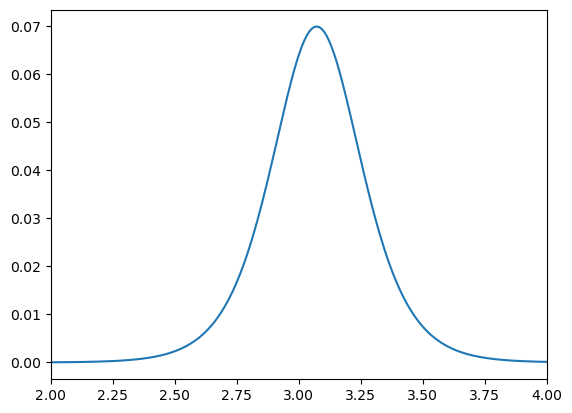

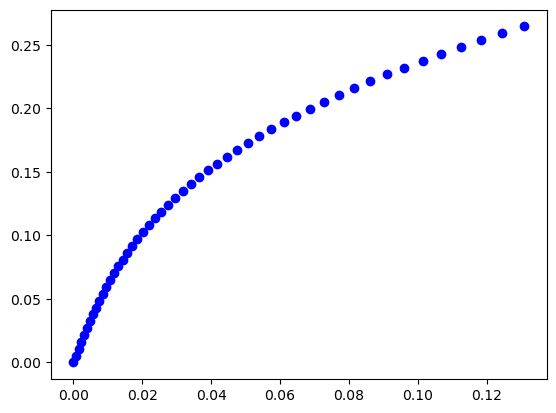

In [7]:
# add this line to avoid "ipython is not defined"
%matplotlib inline 
# wave options
water_level = ipt.mwl
wave_height = ipt.Hm
wave_direction = np.array([1., 0., 0.])
x0 = ipt.x0
trans = np.array([x0, 0., 0.])
fast = ipt.fast

wave = wt.SolitaryWave(waveHeight=wave_height,
                       mwl=water_level,
                       depth=water_level,
                       g=g,
                       waveDir=wave_direction,
                       trans = trans,
                       fast = fast)

# plot free-surface elevation histories
tnList = np.linspace(0.,10.,1000)
wg = []
vn1 = []
vn2 = []
for i in range(len(tnList)):
    wg.append(wave.eta([0.,0.,0.],tnList[i]))
    vn1.append(wave.u([0.,0.02,0.],tnList[i])[0])
    vn2.append(wave.u([0.,0.15,0.],tnList[i])[0])

# plot velocity distribution
nwgy = 50
wgy = np.zeros((len(tnList),nwgy))
vni = np.zeros((len(tnList),nwgy))
for i in range(len(tnList)):
    wgy[i][:] = np.linspace(0.,water_level+wg[i],nwgy)
    for j in range(nwgy):
        vni[i][j] = wave.u([0.,wgy[i][j],0.],tnList[i])[1]
        
plt.figure(1)
plt.plot(tnList,wg)
plt.xlim(2., 4.)
plt.figure(2)
plt.plot(vni[300][:],wgy[300][:],'ob')
# plt.ylim(0., 0.28)


In [11]:
#----------------------------------------------------------------
# define domain
#----------------------------------------------------------------
toe_x = ipt.toe_x
toe_y = ipt.toe_y
slope = ipt.slope
assert water_level >= toe_y, "free surface below seawall (not done yet)"

# length of the free surface
L = (water_level-toe_y)/slope+toe_x

# cell number on free surface
nel = int(math.ceil(L/he))

#----------------------------------------------------------------
# DOMAIN
#----------------------------------------------------------------
boundaryTags = {'bottom': 1,'top': 2,'left': 3,'right': 4,}

#boundaryOrientations = {'bottom': np.array([0., -1.,0.]),
#                        'top': np.array([0., +1.,0.]),
#                        'left': np.array([-1., 0.,0.]),
#                        'right': np.array([+1., 0.,0.]),
#}

# first give bathymetry vertices
vertices = [( 0.0,  0.),
            (10.0,  0.),
            (toe_x, toe_y),
            ( L,    water_level)]

# then give the free-surface vertices 
dx = L/nel
for i in range(nel):
    xi = L-dx*(i+1)
    yi = water_level
    vertices.append((xi,yi))

vertexFlags = [boundaryTags['bottom'],
               boundaryTags['bottom'],
               boundaryTags['bottom']]
for i in range(nel+1):
    vertexFlags += [boundaryTags['top']]

nVertices = len(vertices)
segments = [(i, (i+1)%nVertices) for i in range(nVertices)]

segmentFlags = [boundaryTags['bottom'],
                boundaryTags['bottom'],
                boundaryTags['bottom'],]
for i in range(nel):
    segmentFlags += [boundaryTags['top']]
segmentFlags += [boundaryTags['left']]

regions = [[0.1, 0.1]]
regionFlags=np.array([1])

physics.domain = Domain.PlanarStraightLineGraphDomain(vertices=vertices, # does not work for quadrilateral mesh
                                                      segments=segments,
                                                      regions=regions,
                                                      vertexFlags=vertexFlags,
                                                      segmentFlags=segmentFlags,
                                                      regionFlags=regionFlags)

#----------------------------------------------------------------
# define physics
#----------------------------------------------------------------
physics.coefficients = PoissonEquationCoefficients([a],[r]) 
physics.name="PoissonDots"
physics.nd = 2 # dimension

physics.domain.boundaryTags = boundaryTags
physics.domain.writePoly('trimesh')

#physics.domain.MeshOptions.he = he
#physics.domain.meshOptions.genMesh = True
#physics.domain.meshOptions.nn = None
#physics.domain.meshOptions.nnx  = None 
#physics.domain.meshOptions.nny = None
#physics.domain.meshOptions.triangleOptions = "q30DenAa0.1"

#----------------------------------------------------------------
# define BCs
#----------------------------------------------------------------

def free_surface_bc():
    return 100


# giving mixed type BC
def getDBC(x,flag):
    if flag in [physics.domain.boundaryTags['top']]:
        return lambda x,t: free_surface_bc() #lambda x,t: 0. #af*np.sin(math.pi*(x[0]-0.5*L)/L)*np.cosh(math.pi*x[1]/L)

def getIBC1(x,flag):
    if flag in [physics.domain.boundaryTags['left']]:
        return lambda x,t: wave.u(x,t)[0] #-af*(math.pi/L)*np.cos(math.pi*(x[0]-0.5*L)/L)*np.cosh(math.pi*x[1]/L)

def getIBC2(x,flag):
    if flag in [physics.domain.boundaryTags['right']]:
        return lambda x,t: 0. #af*(math.pi/L)*np.cos(math.pi*(x[0]-0.5*L)/L)*np.cosh(math.pi*x[1]/L)

def getIBC3(x,flag):
    if flag in [physics.domain.boundaryTags['bottom']]:
        return lambda x,t: 0. #-af*(math.pi/L)*np.sin(math.pi*(x[0]-0.5*L)/L)*np.sinh(math.pi*x[1]/L)
    

    
physics.dirichletConditions = {0:getDBC}
physics.fluxBoundaryConditions = {0:getIBC1}
physics.fluxBoundaryConditions = {0:getIBC2}
physics.fluxBoundaryConditions = {0:getIBC3}

#----------------------------------------------------------------
# define numerics
#----------------------------------------------------------------
numerics=default_n
numerics.femSpaces = {0:FemTools.P1}
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,3)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,3)
#numerics.nn = 41

numerics.genMesh = True
numerics.nn = None
numerics.nnx  = None 
numerics.nny = None

# adjust mesh size (for triangle mesh only)
#numerics.triangleOptions = "q30DenAa0.1"
physics.domain.MeshOptions.triangleOptions = "VApq30Dena%8.8f" % ((he **2)/2.0,)

numerics.numericalFluxType = NumericalFlux.Diffusion_SIPG_exterior
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = [0,0.5,1]
# so.tnList=[0.0,dt_init]+[dt_init+ i*dt_out for i in range(1,nDTout+1)]

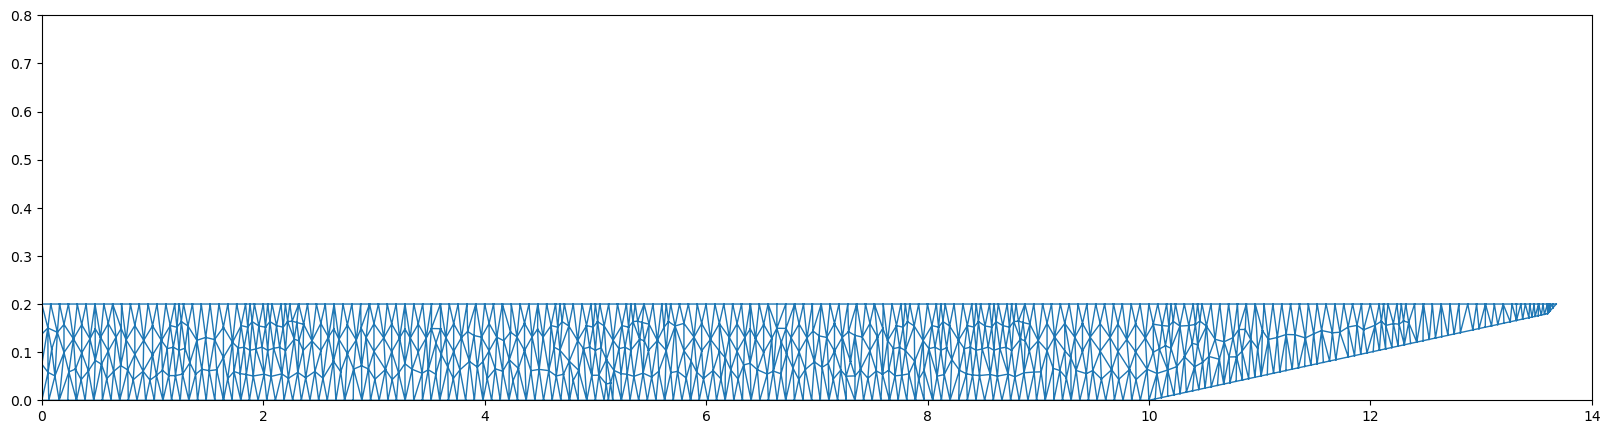

In [9]:
# add this line to avoid "ipython is not defined"
%matplotlib inline 
#----------------------------------------------------------------
# plot mesh
#----------------------------------------------------------------
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
failed = ns.calculateSolution('bvpsolver')
assert(not failed)

model = ns.modelList[0].levelModelList[-1]

x = model.mesh.nodeArray[:,0:2] # note that in 2D case, the third column of nodeArray is zero
n = len(x)
nnode = model.u[0].femSpace.dofMap.nDOF
ln = model.u[0].femSpace.dofMap.l2g
ne = len(ln)
phi = model.u[0].dof
triang = tri.Triangulation(x[:,0],x[:,1],ln)

# for P2 quadratic triangle
#x = model.u[0].femSpace.dofMap.lagrangeNodesArray[:,0:2]
#nnode = model.u[0].femSpace.dofMap.nDOF
#ln = model.u[0].femSpace.dofMap.l2g
#ne = len(ln)
#triang = tri.Triangulation(x[:,0],x[:,1],ln)

#----------------------------------------------------------------
# model.u[0].femSpace.dofMap.l2g returns the nodes of a element
# model.u[0].femSpace.elementMaps.mesh.elementNodesArray returns the end nodes of a element
# if it is a linear triangular element, they are the same
#----------------------------------------------------------------

# plot P1 linear triangles
plt.figure(figsize=(20,5));
plt.triplot(triang, lw=1) #'bo-',
plt.xlim(0., 14.)
plt.ylim(0., 0.8)
plt.show()


In [13]:
# Q1 get free-surface velocity
print(physics.domain.boundaryTags['top'])
def free_surface_bc_need_velocity():
    if flag in [physics.domain.boundaryTags['top']]:
        print(u)
        return

# Q2 remesh after updating free surface or track every node
# Q3 make a module that can directly use variables in Proteus

2


In [10]:
import PTFlow

flowfield = PTFlow.Potential_field(grav=grav,
                                   h=water_level,
                                   n=n,
                                   ne=ne,
                                   ln=ln,
                                   x=x,
                                   phi=phi)

unod = flowfield.v_Galerkin()


print(unod)


newfield = Time_marching(dt=sampleRate,
                         grav=grav,
                         h=water_level,
                         n=n,
                         ne=ne,
                         ln=ln,
                         x=x,
                         phi=phi)

# [new_x,new_phi] = 


# plt.figure(1)
# #plt.figure(figsize=(16,4)) #; plt.rcParams.update({'font.size': 22})
# for eN, e in enumerate(ln):
#     element_nodes = x[e[0]], x[e[1]], x[e[2]]
#     X = [n[0] for n in element_nodes]; Y = [n[1] for n in element_nodes]
#     X.append(element_nodes[0][0]); Y.append(element_nodes[0][1])
#     #plt.plot(X,Y,'-k',linewidth=0.5) #;plt.savefig('C{0:04d}.png'.format(step))
# plt.quiver(x[:,0],x[:,1],unod[:,0],unod[:,1]) #,scale=0.5,width=0.002)
# plt.show()
    
#plt.figure(3)
#plt.subplot(1,2,1)
#plt.tricontourf(triang,unod[:,0],50)
#plt.subplot(1,2,2)
#plt.tricontourf(triang,unod[:,1],50)
#plt.show()

[[ 8.33234372e-14 -5.90746130e-15]
 [-3.85091537e-13  1.03692155e-12]
 [ 1.64724833e-12 -3.34358087e-14]
 ...
 [ 9.82517694e-14 -2.87528016e-13]
 [-6.28766041e-13  1.07114946e-15]
 [-1.61184139e-13 -2.13966931e-13]]
